# Install Imports

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy pillow scikit-image matplotlib

  Using cached https://files.pythonhosted.org/packages/a6/fc/36e52d0ae2aa502b211f1bcd2fdeec72d343d58224eabcdddc1bcb052db1/numpy-1.19.4-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 25.9MB 35kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 2.2MB 436kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 12.4MB 87kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 11.6MB 89kB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 1.6MB 581kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 4.4MB 228kB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 3.3MB 329kB/s 
  C

# Import Modules

In [2]:
import numpy as np

import scipy.ndimage as ndimage

from skimage.metrics import structural_similarity as ssim

from PIL import Image

# Define Metrics

Root Mean Squared Error   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)
  
Mean Squared Error   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)
  
Structural Similarity Index   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)

In [3]:
def rmse(src, dst):
    return np.sqrt(np.mean(np.square(src - dst)))


def mse(src, dst):
    return np.linalg.norm(src - dst)


def metric(src, dst):
    
    rms = rmse(src, dst)
    ms = mse(src, dst)
    sim = ssim(src, dst, multichannel=True)
    
    return rms, ms, sim

# Pooling-based time aware color smoothing



In [4]:
def running_pooling(matrix, neighbors, frames, steps=2, step_at_two=False):
    work_matrix = np.copy(matrix)
    return_matrix = np.copy(matrix)

    # Set step start
    step_idx = 1 if step_at_two else 0
    
    voting_matrix = [[1 if (i < neighbors / 2 and j <= (i + 1 - step_idx) * steps) or (i == int(neighbors / 2)) or (i > neighbors / 2 and j <= (neighbors - i - step_idx) * steps) else 0 for j in range(frames)] for i in range(neighbors)]
    voting_matrix = np.array(voting_matrix).astype('bool')
    
    # Append ones at top and bottom
    work_matrix = np.concatenate((np.ones((int(neighbors / 2), work_matrix.shape[1], work_matrix.shape[2])), work_matrix), axis=0)
    work_matrix = np.concatenate((work_matrix, np.ones((int(neighbors / 2), work_matrix.shape[1], work_matrix.shape[2]))), axis=0)
    
    # Append ones at end
    work_matrix = np.append(work_matrix, np.ones((work_matrix.shape[0], frames - 1, work_matrix.shape[2])), axis=1)
   
    for i in range(work_matrix.shape[1] - frames + 1):
        y_work_matrix = work_matrix[:,i:i + frames]
        for j in range(y_work_matrix.shape[0] - neighbors + 1):
            y_sub_work_matrix = y_work_matrix[j:j + neighbors]
            voted_matrix = y_sub_work_matrix[voting_matrix]
            voted_matrix = voted_matrix[voted_matrix[:,2].argsort()]
            voted_matrix = voted_matrix[voted_matrix[:,1].argsort(kind='mergesort')]
            voted_matrix = voted_matrix[voted_matrix[:,0].argsort(kind='mergesort')]
            value = np.median(voted_matrix, axis=0)
            return_matrix[j, i] = value
    
    return return_matrix

# Gaussian Blur

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



In [5]:
def running_gaussian(matrix, sigma):
    return_matrix = np.copy(matrix)

    for i in range(im2arr.shape[1]):
        return_matrix[:,i] = ndimage.gaussian_filter(matrix[:,i], sigma=sigma, order=0)
        
    return return_matrix

# Load Spatial Rug

 - Load image data
 - Transform it to numpy array
 - Smooth by pooling
 - Smooth by Gaussian

In [6]:
rugs_path = 'rugs/'

im = Image.open(rugs_path + 'originalspatialrug.png')
im2arr = np.array(im)
arr2im = Image.fromarray(im2arr)

im2arr_neighbor = running_pooling(im2arr, 15, 15, 2) # Change parameters here

im2arr_smooth = running_gaussian(im2arr, (5, 0)) # Change parameters here

# Results

--------------------------------------------------
--------------- Voting ---------------------------
--------------------------------------------------
Metrics (RMSE, MSE, SSIM):  (7.555981870736924, 155491.53995314342, 0.5383207146723143)
--------------------------------------------------


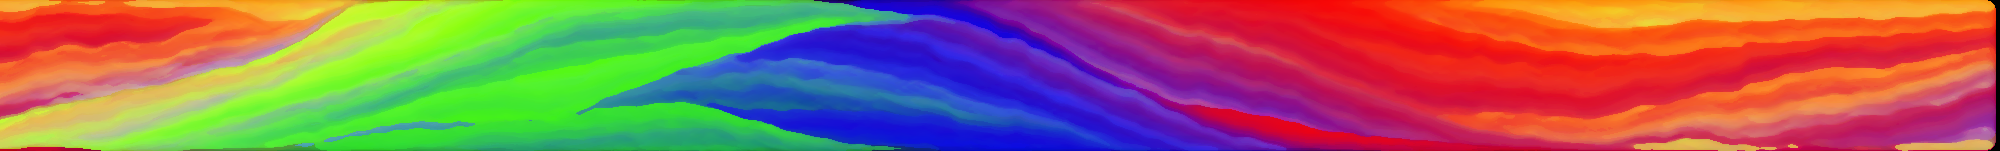

In [7]:
print('--------------------------------------------------')
print('--------------- Voting ---------------------------')
print('--------------------------------------------------')
print('Metrics (RMSE, MSE, SSIM): ', metric(im2arr, im2arr_neighbor))
print('--------------------------------------------------')

Image.fromarray(im2arr_neighbor)

--------------------------------------------------
--------------- Gaussian -------------------------
--------------------------------------------------
Metrics (RMSE, MSE, SSIM):  (8.040792109509136, 160243.9953508399, 0.5327152543297738)
--------------------------------------------------


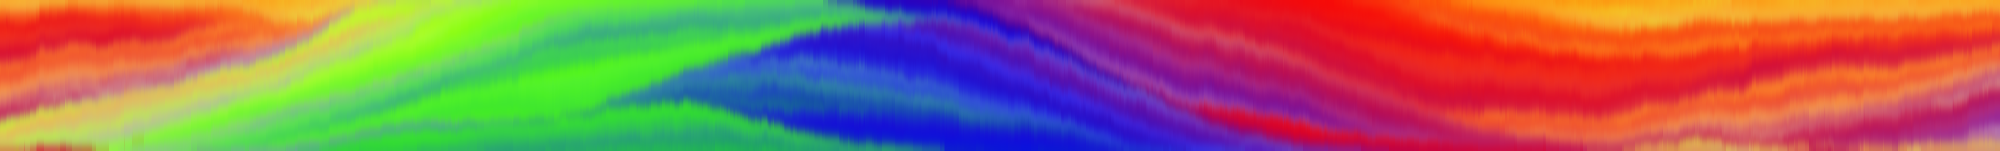

In [8]:
print('--------------------------------------------------')
print('--------------- Gaussian -------------------------')
print('--------------------------------------------------')
print('Metrics (RMSE, MSE, SSIM): ', metric(im2arr, im2arr_smooth))
print('--------------------------------------------------')

Image.fromarray(im2arr_smooth)

--------------------------------------------------
--------------- Original -------------------------
Metrics (RMSE, MSE, SSIM):  (0.0, 0.0, 1.0)
--------------------------------------------------


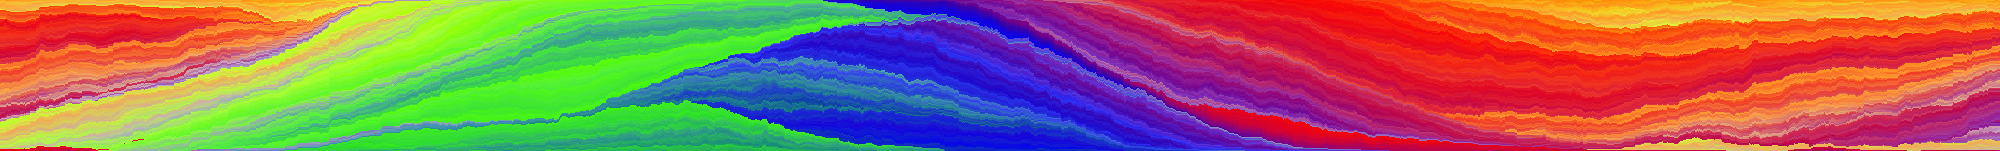

In [9]:
print('--------------------------------------------------')
print('--------------- Original -------------------------')
print('Metrics (RMSE, MSE, SSIM): ', metric(im2arr, im2arr))
print('--------------------------------------------------')

Image.fromarray(im2arr)

array([[     0, 261792],
       [     1,  40208]])

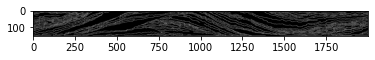

In [10]:
from skimage import feature
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

grayscale = rgb2gray(im2arr)
edges1 = feature.canny(grayscale)

plt.imshow(edges1, cmap=plt.cm.gray)

unique, counts = np.unique(edges1, return_counts=True)
np.asarray((unique, counts)).T

array([[     0, 288543],
       [     1,  13457]])

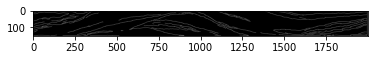

In [11]:
grayscale = rgb2gray(im2arr_neighbor)
edges1 = feature.canny(grayscale)

plt.imshow(edges1, cmap=plt.cm.gray)

unique, counts = np.unique(edges1, return_counts=True)
np.asarray((unique, counts)).T

array([[     0, 298982],
       [     1,   3018]])

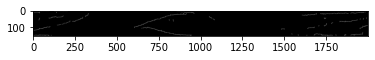

In [12]:
grayscale = rgb2gray(im2arr_smooth)
edges1 = feature.canny(grayscale)

plt.imshow(edges1, cmap=plt.cm.gray)

unique, counts = np.unique(edges1, return_counts=True)
np.asarray((unique, counts)).T